# Kernel EDMD + KSWGD on Torus T²

This notebook implements **Kernel Extended Dynamic Mode Decomposition (EDMD)** combined with **KSWGD** on a **Torus manifold**.

## Torus Parametrization

The torus $T^2$ is embedded in $\mathbb{R}^3$ using angles $(\theta, \phi) \in [0, 2\pi)^2$:

$$
\begin{aligned}
x &= (R + r\cos\phi)\cos\theta \\
y &= (R + r\cos\phi)\sin\theta \\
z &= r\sin\phi
\end{aligned}
$$

- $R$: Major radius (center to tube center)
- $r$: Minor radius (tube radius)

## Exact SDE for Brownian Motion on Torus

**Stratonovich SDE** (pure diffusion, uniform invariant measure):
$$
d\theta = \frac{\sqrt{2}}{R + r\cos\phi} \circ dW_t^1, \quad
d\phi = \frac{\sqrt{2}}{r} \circ dW_t^2
$$

**Equivalent Itô SDE** (with Wong-Zakai correction):
$$
d\theta = \frac{\sin\phi}{r(R + r\cos\phi)^2} dt + \frac{\sqrt{2}}{R + r\cos\phi} dW_t^1, \quad
d\phi = \frac{\sqrt{2}}{r} dW_t^2
$$

The drift term in $\theta$ arises from the curvature of the torus - particles diffuse faster on the inner side (smaller circumference) than the outer side.

## 1. Import Libraries and GPU/CPU Backend Configuration

In [1]:
import numpy as np
from scipy.linalg import svd, eigh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time

# --------------- Optional GPU backend (CuPy) ---------------
USE_GPU = True  # Set False to force CPU even if CuPy is available
try:
    import cupy as cp  # type: ignore
    GPU_AVAILABLE = True
except Exception:
    cp = None  # type: ignore
    GPU_AVAILABLE = False
USE_GPU = bool(USE_GPU and GPU_AVAILABLE)
if USE_GPU:
    from grad_ker1_gpu import grad_ker1
    from K_tar_eval_gpu import K_tar_eval
else:
    from grad_ker1 import grad_ker1
    from K_tar_eval import K_tar_eval

print(f"[DEVICE] {'GPU' if USE_GPU else 'CPU'} mode active")

[DEVICE] GPU mode active


## 2. Define Timing and Progress Utility Functions

In [2]:
# ---------------- Timing / Progress Utilities ----------------
def _fmt_secs(s: float) -> str:
    s = max(0.0, float(s))
    h = int(s // 3600)
    m = int((s % 3600) // 60)
    sec = int(s % 60)
    if h > 0:
        return f"{h:02d}:{m:02d}:{sec:02d}"
    return f"{m:02d}:{sec:02d}"

def _print_phase(name: str, t_start: float) -> float:
    dt = time.time() - t_start
    print(f"[TIMER] {name}: {dt:.3f}s")
    return time.time()

_LAST_PROGRESS_LEN = 0
def _print_progress(curr: int, total: int, start_time: float, prefix: str = "") -> None:
    global _LAST_PROGRESS_LEN
    total = max(1, int(total))
    curr = min(max(0, curr), total)
    bar_len = 30
    filled = int(bar_len * curr / total)
    filled = min(filled, bar_len)
    bar = ("=" * filled) + (">" if filled < bar_len else "") + ("." * max(0, bar_len - filled - (0 if filled == bar_len else 1)))
    pct = 100.0 * curr / total
    elapsed = time.time() - start_time
    avg = elapsed / max(1, curr)
    eta = avg * (total - curr)
    msg = f"{prefix}[{bar}] {pct:5.1f}% | iter {curr}/{total} | elapsed {_fmt_secs(elapsed)} | eta {_fmt_secs(eta)}"
    prev = _LAST_PROGRESS_LEN
    clear = "\r" + (" " * prev) + "\r"
    print(clear, end="")
    print(msg, end="", flush=True)
    _LAST_PROGRESS_LEN = len(msg)

# Set random seed for reproducibility
np.random.seed(42)
_t = time.time()

## 3. Configuration Parameters

- `R`: Major radius of the torus (center to tube center)
- `r`: Minor radius of the torus (tube radius)
- `KERNEL_TYPE`: Kernel selection (1: RBF, 2: Geodesic-like, 3: Matérn, 4: Rational Quadratic, 5: Polynomial)
- `n`: Number of target sample points
- `d`: Embedding dimension (3 for torus in R³)

In [3]:
# ---------------- Torus Configuration ----------------
R = 2.0   # Major radius (center to tube center)
r = 0.8   # Minor radius (tube radius), must satisfy r < R

KERNEL_TYPE = 2  # 1: RBF, 2: Geodesic-like, 3: Matérn, 4: Rational Quadratic, 5: Polynomial
# NOTE: KERNEL_TYPE=2 (Geodesic) should work better WITHOUT projection
#       because it respects the torus geometry

# ===== PROJECTION SWITCH =====
USE_PROJECTION = False  # True: project particles back to torus after each step ("cheating")
                        # False: let KSWGD learn the manifold from data alone

# ===== RIEMANNIAN GRADIENT SWITCH =====
USE_RIEMANNIAN_GRADIENT = True  # True: project gradient to tangent space (Riemannian gradient)
                                 # False: use Euclidean gradient in R³

# ===== TANGENT SPACE ESTIMATION METHOD =====
# 'analytic': use known torus formula (CHEATING - requires knowing the manifold)
# 'local_pca': data-driven estimation using local PCA on X_tar (NO CHEATING)
TANGENT_SPACE_METHOD = 'local_pca'
LOCAL_PCA_K_NEIGHBORS = 30  # Number of neighbors for local PCA
MANIFOLD_DIM = 2  # Intrinsic dimension of the manifold (torus is 2D)

# Number of target sample points
n = 800

d = 3  # Embedding dimension (torus lives in R³)

print(f"[CONFIG] Torus parameters: R={R}, r={r}")
print(f"[CONFIG] Number of samples: n={n}")
print(f"[CONFIG] USE_PROJECTION = {USE_PROJECTION}")
print(f"[CONFIG] USE_RIEMANNIAN_GRADIENT = {USE_RIEMANNIAN_GRADIENT}")
if USE_RIEMANNIAN_GRADIENT:
    print(f"[CONFIG] TANGENT_SPACE_METHOD = '{TANGENT_SPACE_METHOD}'")
    if TANGENT_SPACE_METHOD == 'local_pca':
        print(f"[CONFIG] LOCAL_PCA_K_NEIGHBORS = {LOCAL_PCA_K_NEIGHBORS}, MANIFOLD_DIM = {MANIFOLD_DIM}")

[CONFIG] Torus parameters: R=2.0, r=0.8
[CONFIG] Number of samples: n=800
[CONFIG] USE_PROJECTION = False
[CONFIG] USE_RIEMANNIAN_GRADIENT = True
[CONFIG] TANGENT_SPACE_METHOD = 'local_pca'
[CONFIG] LOCAL_PCA_K_NEIGHBORS = 30, MANIFOLD_DIM = 2


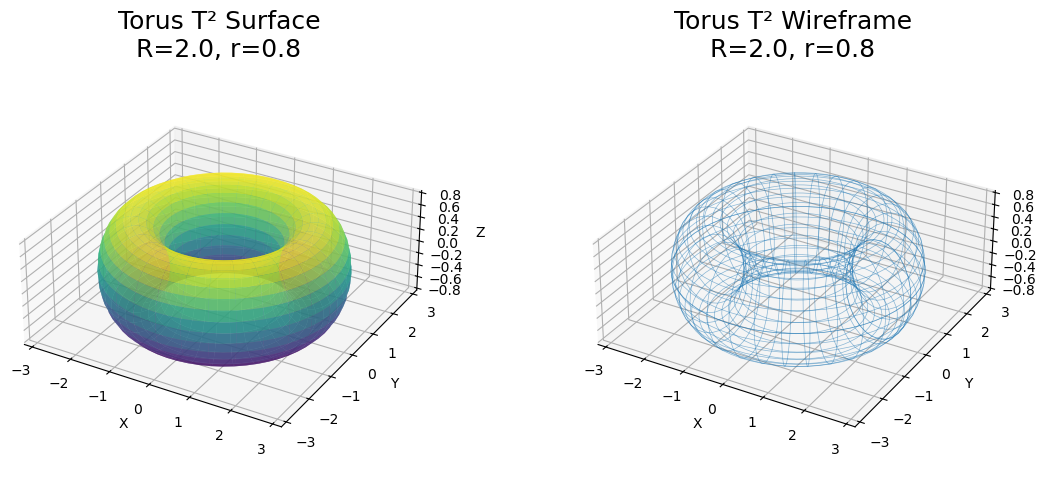

[INFO] Torus geometry: Major radius R=2.0, Minor radius r=0.8
[INFO] Torus extends from x,y ∈ [-2.8, 2.8], z ∈ [-0.8, 0.8]


In [4]:
# Visualize the torus surface
fig = plt.figure(figsize=(12, 5))

# Create mesh grid for torus surface
theta_mesh = np.linspace(0, 2 * np.pi, 60)
phi_mesh = np.linspace(0, 2 * np.pi, 30)
THETA, PHI = np.meshgrid(theta_mesh, phi_mesh)

# Parametric equations for torus
X_mesh = (R + r * np.cos(PHI)) * np.cos(THETA)
Y_mesh = (R + r * np.cos(PHI)) * np.sin(THETA)
Z_mesh = r * np.sin(PHI)

# Plot 1: Surface plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X_mesh, Y_mesh, Z_mesh, cmap='viridis', alpha=0.7, edgecolor='none')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title(f'Torus T² Surface\nR={R}, r={r}', fontsize=18)
ax1.set_box_aspect([1, 1, 0.4])

# Plot 2: Wireframe plot (shows structure better)
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_wireframe(X_mesh, Y_mesh, Z_mesh, color='C0', alpha=0.5, linewidth=0.5)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title(f'Torus T² Wireframe\nR={R}, r={r}', fontsize=18)
ax2.set_box_aspect([1, 1, 0.4])

plt.tight_layout()
plt.show()

print(f"[INFO] Torus geometry: Major radius R={R}, Minor radius r={r}")
print(f"[INFO] Torus extends from x,y ∈ [{-(R+r):.1f}, {R+r:.1f}], z ∈ [{-r:.1f}, {r:.1f}]")

## 4. Torus Helper Functions

Define functions to:
1. Convert between angular coordinates $(\theta, \phi)$ and Cartesian $(x, y, z)$
2. Compute tangent vectors and normal vectors on the torus

In [5]:
def angles_to_cartesian(theta, phi, R, r):
    """
    Convert angular coordinates (theta, phi) to Cartesian (x, y, z).
    
    Parameters:
        theta: array of shape (n,) - angle around the major circle [0, 2π)
        phi: array of shape (n,) - angle around the minor circle [0, 2π)
        R: major radius
        r: minor radius
    
    Returns:
        X: array of shape (n, 3) - Cartesian coordinates
    """
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)
    return np.column_stack([x, y, z])

def cartesian_to_angles(X, R, r):
    """
    Convert Cartesian coordinates (x, y, z) back to angular (theta, phi).
    
    Parameters:
        X: array of shape (n, 3) - Cartesian coordinates
        R: major radius
        r: minor radius
    
    Returns:
        theta: array of shape (n,) - angle around major circle [0, 2π)
        phi: array of shape (n,) - angle around minor circle [0, 2π)
    """
    x, y, z = X[:, 0], X[:, 1], X[:, 2]
    theta = np.arctan2(y, x)
    theta = np.mod(theta, 2 * np.pi)  # Ensure [0, 2π)
    
    # Distance from z-axis
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(z, rho - R)
    phi = np.mod(phi, 2 * np.pi)  # Ensure [0, 2π)
    
    return theta, phi

def compute_torus_tangent_normal(theta, phi, R, r):
    """
    Compute unit tangent vectors and normal vector at each point on the torus.
    
    Returns:
        e_theta: (n, 3) unit tangent in theta direction
        e_phi: (n, 3) unit tangent in phi direction
        normal: (n, 3) outward unit normal
    """
    n_pts = len(theta)
    
    # Partial derivatives (not normalized)
    # ∂X/∂θ = (-(R + r cos φ) sin θ, (R + r cos φ) cos θ, 0)
    dx_dtheta = np.column_stack([
        -(R + r * np.cos(phi)) * np.sin(theta),
        (R + r * np.cos(phi)) * np.cos(theta),
        np.zeros(n_pts)
    ])
    
    # ∂X/∂φ = (-r sin φ cos θ, -r sin φ sin θ, r cos φ)
    dx_dphi = np.column_stack([
        -r * np.sin(phi) * np.cos(theta),
        -r * np.sin(phi) * np.sin(theta),
        r * np.cos(phi)
    ])
    
    # Normalize to get unit tangent vectors
    e_theta = dx_dtheta / (np.linalg.norm(dx_dtheta, axis=1, keepdims=True) + 1e-12)
    e_phi = dx_dphi / (np.linalg.norm(dx_dphi, axis=1, keepdims=True) + 1e-12)
    
    # Normal vector (cross product of tangents)
    normal = np.cross(e_theta, e_phi)
    normal = normal / (np.linalg.norm(normal, axis=1, keepdims=True) + 1e-12)
    
    return e_theta, e_phi, normal

def project_to_torus(X, R, r):
    """
    Project points in R³ onto the nearest point on the torus surface.
    
    This is used for numerical stability after Euler-Maruyama updates.
    """
    # Convert to angles and back
    theta, phi = cartesian_to_angles(X, R, r)
    return angles_to_cartesian(theta, phi, R, r)

## 5. Generate Target Distribution Samples (X_tar)

Sample uniformly on the torus $T^2$. The uniform measure on torus is:
$$
d\mu = (R + r\cos\phi) \, d\theta \, d\phi
$$

We use rejection sampling to account for the $(R + r\cos\phi)$ factor.

In [6]:
# Uniform sampling on torus using rejection sampling
# The density is proportional to (R + r*cos(phi))

samples_theta = []
samples_phi = []
max_density = R + r  # Maximum value of (R + r*cos(phi))

while len(samples_theta) < n:
    # Propose uniform angles
    batch_size = int((n - len(samples_theta)) * 1.5) + 100
    theta_prop = np.random.uniform(0, 2 * np.pi, batch_size)
    phi_prop = np.random.uniform(0, 2 * np.pi, batch_size)
    
    # Accept with probability proportional to (R + r*cos(phi)) / max_density
    density = R + r * np.cos(phi_prop)
    accept_prob = density / max_density
    u = np.random.uniform(0, 1, batch_size)
    accept = u < accept_prob
    
    samples_theta.extend(theta_prop[accept])
    samples_phi.extend(phi_prop[accept])

# Take exactly n samples
theta_tar = np.array(samples_theta[:n])
phi_tar = np.array(samples_phi[:n])

# Convert to Cartesian coordinates
X_tar = angles_to_cartesian(theta_tar, phi_tar, R, r)
print(f"[INFO] Generated {n} uniformly distributed points on torus T²")
print(f"[INFO] X_tar shape: {X_tar.shape}, range: [{X_tar.min():.2f}, {X_tar.max():.2f}]")

[INFO] Generated 800 uniformly distributed points on torus T²
[INFO] X_tar shape: (800, 3), range: [-2.78, 2.79]


[SAVED] Interactive 3D plot saved to: figures/torus/X_tar_torus_interactive.html
        Open this file in a browser to rotate/zoom the plot!


c:\Users\xyc93\miniconda3\envs\gpu\Lib\site-packages\plotly\offline\offline.py:152: UserWarning:


Unrecognized config options supplied: ['mathjax']



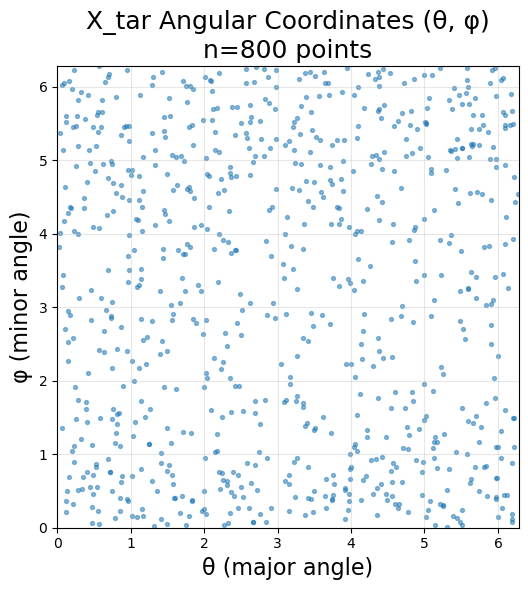


[INFO] In angular space, density ∝ (R + r·cos(φ))
[INFO] Outer edge (φ≈0): higher density | Inner edge (φ≈π): lower density


In [22]:
# Visualize X_tar uniform distribution on torus
import plotly.graph_objects as go
import os

# ============ Plot 1: Interactive 3D scatter (Plotly - can rotate!) ============
# Create torus surface mesh for reference
theta_surf = np.linspace(0, 2 * np.pi, 50)
phi_surf = np.linspace(0, 2 * np.pi, 30)
THETA_S, PHI_S = np.meshgrid(theta_surf, phi_surf)
X_surf = (R + r * np.cos(PHI_S)) * np.cos(THETA_S)
Y_surf = (R + r * np.cos(PHI_S)) * np.sin(THETA_S)
Z_surf = r * np.sin(PHI_S)

fig_3d = go.Figure()

# Add torus surface (semi-transparent)
fig_3d.add_trace(go.Surface(
    x=X_surf, y=Y_surf, z=Z_surf,
    opacity=0.3,
    colorscale='Viridis',
    showscale=False,
    name='Torus Surface'
))

# Add X_tar scatter points
fig_3d.add_trace(go.Scatter3d(
    x=X_tar[:, 0], y=X_tar[:, 1], z=X_tar[:, 2],
    mode='markers',
    marker=dict(size=3, color='blue', opacity=0.7),
    name=f'X_tar (n={n})'
))

# Build title with proper text and math separation
title_text = f'X_tar: Uniform Distribution on Torus 𝕋² (n={n}) | R={R}, r={r}'
fig_3d.update_layout(
    title=dict(
        text=title_text,
        font=dict(size=16)
    ),
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'
    ),
    width=800,
    height=600
)

# Save interactive HTML file (with MathJax enabled for LaTeX rendering)
os.makedirs('figures/torus', exist_ok=True)
html_path = 'figures/torus/X_tar_torus_interactive.html'
fig_3d.write_html(html_path, include_mathjax='cdn')
print(f"[SAVED] Interactive 3D plot saved to: {html_path}")
print(f"        Open this file in a browser to rotate/zoom the plot!")

# Display in notebook (with fallback)
try:
    fig_3d.show(config={'mathjax': 'cdn'})
except Exception as e:
    print(f"[INFO] Cannot display interactive plot in notebook: {e}")
    print(f"[INFO] Please open the HTML file in browser: {html_path}")

# ============ Plot 2: Angular coordinates (θ, φ) - Matplotlib ============
fig2, ax2 = plt.subplots(figsize=(7, 6))
ax2.scatter(theta_tar, phi_tar, s=8, c='C0', alpha=0.5)
ax2.set_xlabel('θ (major angle)', fontsize=16)
ax2.set_ylabel('φ (minor angle)', fontsize=16)
ax2.set_xlim(0, 2*np.pi)
ax2.set_ylim(0, 2*np.pi)
ax2.set_aspect('equal')
ax2.set_title(f'X_tar Angular Coordinates (θ, φ)\nn={n} points', fontsize=18)
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Note: In (θ, φ) space, uniform on torus means MORE points at φ≈0 (outer edge)
# and FEWER points at φ≈π (inner edge), due to the (R + r*cos(φ)) factor
print(f"\n[INFO] In angular space, density ∝ (R + r·cos(φ))")
print(f"[INFO] Outer edge (φ≈0): higher density | Inner edge (φ≈π): lower density")

## 6. Generate X_tar_next via Exact Torus SDE

**Itô SDE for Brownian motion on torus:**
$$
d\theta = \underbrace{\frac{\sin\phi}{r(R + r\cos\phi)^2}}_{\text{Itô correction}} dt + \frac{\sqrt{2}}{R + r\cos\phi} dW_t^1
$$
$$
d\phi = \frac{\sqrt{2}}{r} dW_t^2
$$

Key points:
- The drift term in $\theta$ is the **Itô-Stratonovich correction** (Wong-Zakai correction)
- This correction arises because the diffusion coefficient depends on $\phi$
- The $\phi$ equation has constant diffusion coefficient, so no correction needed

In [8]:
# Time step for SDE integration
dt_edmd = 0.05

# Current angular coordinates
theta_curr = theta_tar.copy()
phi_curr = phi_tar.copy()

# Metric factors
g_theta = R + r * np.cos(phi_curr)  # sqrt(g_θθ) = R + r*cos(φ)
g_phi = r  # sqrt(g_φφ) = r (constant)

# ---------- Itô SDE Integration ----------

# 1. Compute Itô correction term for theta equation
#    Correction = (1/2) * d(σ_θ)/dφ * σ_φ²
#    where σ_θ = 1/(R + r*cos(φ)), σ_φ = 1/r
#    d(σ_θ)/dφ = r*sin(φ) / (R + r*cos(φ))²
#    Correction = sin(φ) / [r * (R + r*cos(φ))²]
ito_correction_theta = np.sin(phi_curr) / (r * g_theta**2)

# 2. Diffusion coefficients (in angular coordinates)
sigma_theta = np.sqrt(2) / g_theta  # Diffusion coefficient for θ
sigma_phi = np.sqrt(2) / g_phi      # Diffusion coefficient for φ (constant)

# 3. Generate Brownian increments
dW1 = np.random.normal(0, np.sqrt(dt_edmd), n)  # For θ
dW2 = np.random.normal(0, np.sqrt(dt_edmd), n)  # For φ

# 4. Euler-Maruyama update (Itô form)
theta_next = theta_curr + ito_correction_theta * dt_edmd + sigma_theta * dW1
phi_next = phi_curr + sigma_phi * dW2

# 5. Wrap angles to [0, 2π) - torus is periodic
theta_next = np.mod(theta_next, 2 * np.pi)
phi_next = np.mod(phi_next, 2 * np.pi)

# 6. Convert back to Cartesian coordinates
X_tar_next = angles_to_cartesian(theta_next, phi_next, R, r)

print(f"[SDE] Itô correction magnitude: mean={np.mean(np.abs(ito_correction_theta)):.4f}, max={np.max(np.abs(ito_correction_theta)):.4f}")
print(f"[SDE] Time step dt = {dt_edmd}")
print(f"[SDE] X_tar_next generated via exact torus SDE")

[SDE] Itô correction magnitude: mean=0.2051, max=0.4338
[SDE] Time step dt = 0.05
[SDE] X_tar_next generated via exact torus SDE


## 7. Visualize Time Evolution Pair (X_tar vs X_tar_next)

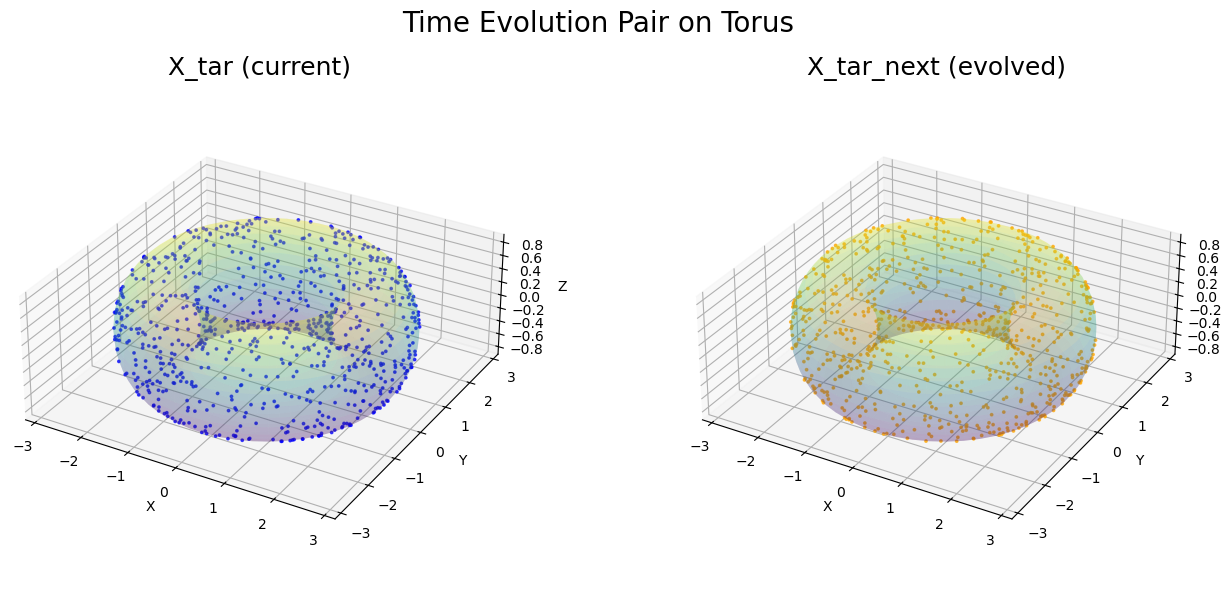

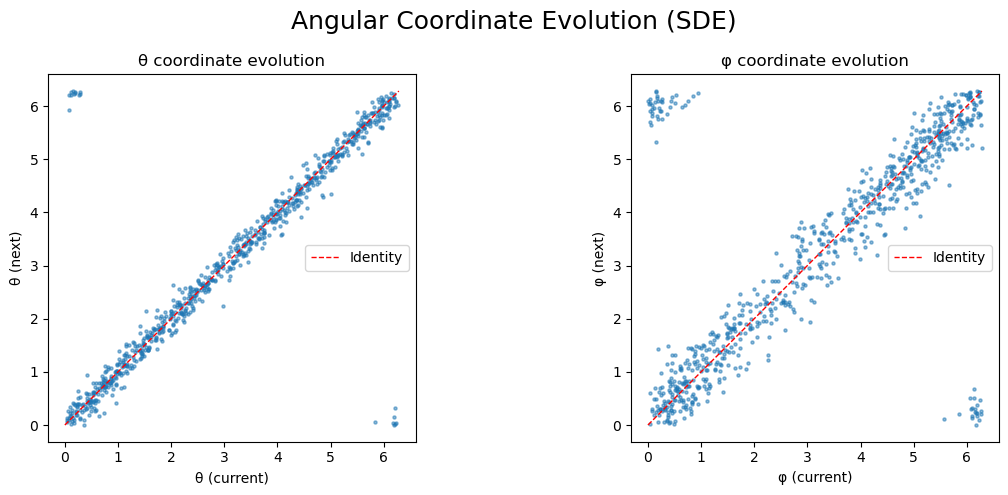

In [9]:
kernel_names = {1: "RBF", 2: "Geodesic-like", 3: "Matérn", 4: "Rational Quadratic", 5: "Polynomial"}
kernel_display = kernel_names.get(KERNEL_TYPE, "Unknown")

fig = plt.figure(figsize=(14, 6))

# Create torus surface mesh for reference (same as Cell 13)
theta_surf = np.linspace(0, 2 * np.pi, 50)
phi_surf = np.linspace(0, 2 * np.pi, 30)
THETA_S, PHI_S = np.meshgrid(theta_surf, phi_surf)
X_surf = (R + r * np.cos(PHI_S)) * np.cos(THETA_S)
Y_surf = (R + r * np.cos(PHI_S)) * np.sin(THETA_S)
Z_surf = r * np.sin(PHI_S)

# Plot X_tar
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X_surf, Y_surf, Z_surf, alpha=0.2, cmap='viridis', edgecolor='none')
ax1.scatter(X_tar[:, 0], X_tar[:, 1], X_tar[:, 2], s=3, c='blue', alpha=0.7)
ax1.set_title('X_tar (current)', fontsize=18)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_box_aspect([1, 1, 0.4])

# Plot X_tar_next
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X_surf, Y_surf, Z_surf, alpha=0.2, cmap='viridis', edgecolor='none')
ax2.scatter(X_tar_next[:, 0], X_tar_next[:, 1], X_tar_next[:, 2], s=3, c='orange', alpha=0.7)
ax2.set_title('X_tar_next (evolved)', fontsize=18)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_box_aspect([1, 1, 0.4])

plt.suptitle(f'Time Evolution Pair on Torus', fontsize=20)
plt.tight_layout()
plt.show()

# Also show angular coordinate evolution
fig2, axes = plt.subplots(1, 2, figsize=(12, 5))

# θ evolution
axes[0].scatter(theta_tar, theta_next, s=5, alpha=0.5)
axes[0].plot([0, 2*np.pi], [0, 2*np.pi], 'r--', lw=1, label='Identity')
axes[0].set_xlabel('θ (current)')
axes[0].set_ylabel('θ (next)')
axes[0].set_title('θ coordinate evolution')
axes[0].legend()
axes[0].set_aspect('equal')

# φ evolution
axes[1].scatter(phi_tar, phi_next, s=5, alpha=0.5)
axes[1].plot([0, 2*np.pi], [0, 2*np.pi], 'r--', lw=1, label='Identity')
axes[1].set_xlabel('φ (current)')
axes[1].set_ylabel('φ (next)')
axes[1].set_title('φ coordinate evolution')
axes[1].legend()
axes[1].set_aspect('equal')

plt.suptitle('Angular Coordinate Evolution (SDE)', fontsize=18)
plt.tight_layout()
plt.show()

## 8. Define Kernel Functions

Five kernel options available:
1. **RBF/Gaussian**: $k(x,y) = \exp(-\|x-y\|^2/(2\varepsilon))$
2. **Geodesic-like**: Approximates geodesic distance on torus
3. **Matérn**: $k(x,y) = (1 + \sqrt{3}\cdot d/\ell)\cdot\exp(-\sqrt{3}\cdot d/\ell)$
4. **Rational Quadratic**: $k(x,y) = (1 + \|x-y\|^2/(2\alpha\cdot\ell^2))^{-\alpha}$
5. **Polynomial**: $k(x,y) = (\gamma\cdot\langle x,y\rangle + c_0)^d$

In [10]:
def kernel1_rbf(X, Y, eps):
    """RBF/Gaussian Kernel"""
    sq_x = np.sum(X ** 2, axis=1)
    sq_y = np.sum(Y ** 2, axis=1)
    D2 = sq_x[:, None] + sq_y[None, :] - 2 * (X @ Y.T)
    D2 = np.maximum(D2, 0)  # Numerical stability
    return np.exp(-D2 / (2 * eps))

def kernel2_geodesic_torus(X, Y, R, r, length_scale=1.0):
    """
    Geodesic-like kernel for torus.
    Uses angular distance as an approximation to geodesic distance.
    """
    # Convert to angles
    theta_x, phi_x = cartesian_to_angles(X, R, r)
    theta_y, phi_y = cartesian_to_angles(Y, R, r)
    
    # Angular differences (account for periodicity)
    d_theta = theta_x[:, None] - theta_y[None, :]
    d_theta = np.minimum(np.abs(d_theta), 2*np.pi - np.abs(d_theta))
    
    d_phi = phi_x[:, None] - phi_y[None, :]
    d_phi = np.minimum(np.abs(d_phi), 2*np.pi - np.abs(d_phi))
    
    # Approximate geodesic distance squared (weighted by metric)
    # Using average metric factor for simplicity
    avg_g_theta = R  # Average of (R + r*cos(φ))
    dist2 = (avg_g_theta * d_theta)**2 + (r * d_phi)**2
    
    return np.exp(-dist2 / (2 * length_scale**2))

def kernel3_matern(X, Y, length_scale=1.0, nu=1.5):
    """Matérn Kernel (ν=1.5)"""
    sq_x = np.sum(X ** 2, axis=1)
    sq_y = np.sum(Y ** 2, axis=1)
    D2 = sq_x[:, None] + sq_y[None, :] - 2 * (X @ Y.T)
    D = np.sqrt(np.maximum(D2, 0))
    sqrt3_D = np.sqrt(3) * D / length_scale
    return (1 + sqrt3_D) * np.exp(-sqrt3_D)

def kernel4_rational_quadratic(X, Y, alpha=1.0, length_scale=1.0):
    """Rational Quadratic Kernel"""
    sq_x = np.sum(X ** 2, axis=1)
    sq_y = np.sum(Y ** 2, axis=1)
    D2 = sq_x[:, None] + sq_y[None, :] - 2 * (X @ Y.T)
    D2 = np.maximum(D2, 0)
    return (1 + D2 / (2 * alpha * length_scale**2)) ** (-alpha)

def kernel5_polynomial(X, Y, degree=3, coef0=1.0, gamma=None):
    """Polynomial Kernel"""
    if gamma is None:
        gamma = 1.0 / X.shape[1]
    inner_prod = X @ Y.T
    return (gamma * inner_prod + coef0) ** degree

## 9. Compute Kernel Matrices (K_xx and K_xy)

In [11]:
# Compute bandwidth parameter based on median heuristic
sq_tar = np.sum(X_tar ** 2, axis=1)
H = sq_tar[:, None] + sq_tar[None, :] - 2 * (X_tar @ X_tar.T)
H = np.maximum(H, 0)
epsilon = 0.5 * np.median(H) / (np.log(n + 1) + 1e-12)
length_scale = np.sqrt(np.median(H))

print(f"[KERNEL] Bandwidth epsilon = {epsilon:.4f}")
print(f"[KERNEL] Length scale = {length_scale:.4f}")

# Select and apply kernel
if KERNEL_TYPE == 1:
    kernel_name = "RBF"
    K_xx = kernel1_rbf(X_tar, X_tar, epsilon)
    K_xy = kernel1_rbf(X_tar, X_tar_next, epsilon)
elif KERNEL_TYPE == 2:
    kernel_name = "Geodesic-like"
    geo_scale = 0.5
    K_xx = kernel2_geodesic_torus(X_tar, X_tar, R, r, length_scale=geo_scale)
    K_xy = kernel2_geodesic_torus(X_tar, X_tar_next, R, r, length_scale=geo_scale)
elif KERNEL_TYPE == 3:
    kernel_name = "Matérn"
    K_xx = kernel3_matern(X_tar, X_tar, length_scale=length_scale, nu=1.5)
    K_xy = kernel3_matern(X_tar, X_tar_next, length_scale=length_scale, nu=1.5)
elif KERNEL_TYPE == 4:
    kernel_name = "Rational Quadratic"
    alpha = 2.0
    K_xx = kernel4_rational_quadratic(X_tar, X_tar, alpha=alpha, length_scale=length_scale)
    K_xy = kernel4_rational_quadratic(X_tar, X_tar_next, alpha=alpha, length_scale=length_scale)
elif KERNEL_TYPE == 5:
    kernel_name = "Polynomial"
    poly_degree = 6
    poly_coef0 = 1.0
    poly_gamma = 1.0 / d
    K_xx = kernel5_polynomial(X_tar, X_tar, degree=poly_degree, coef0=poly_coef0, gamma=poly_gamma)
    K_xy = kernel5_polynomial(X_tar, X_tar_next, degree=poly_degree, coef0=poly_coef0, gamma=poly_gamma)
else:
    raise ValueError(f"Invalid KERNEL_TYPE: {KERNEL_TYPE}")

print(f"[KERNEL] Using {kernel_name} kernel (Type {KERNEL_TYPE})")
_t = _print_phase(f"Kernel-EDMD: Gram matrices K_xx and K_xy ({kernel_name})", _t)

[KERNEL] Bandwidth epsilon = 0.6843
[KERNEL] Length scale = 3.0249
[KERNEL] Using Geodesic-like kernel (Type 2)
[TIMER] Kernel-EDMD: Gram matrices K_xx and K_xy (Geodesic-like): 1.049s


## 10. Compute Koopman Operator via Kernel EDMD

**Formula**: $K_{Koopman} = K_{xy} (K_{xx} + \gamma I)^{-1}$

This approximates the Koopman operator for the dynamics $X_t \to X_{t+dt}$

In [12]:
gamma_ridge = 1e-6  # Tikhonov regularization

# Use eigendecomposition for stable inversion
evals_kxx, Q_kxx = eigh(K_xx)
evals_kxx = np.clip(evals_kxx, 0.0, None)
inv_evals = 1.0 / (evals_kxx + gamma_ridge)
data_kernel = K_xy @ (Q_kxx @ (np.diag(inv_evals) @ Q_kxx.T))

# Safety: ensure finite values
data_kernel = np.nan_to_num(data_kernel, nan=0.0, posinf=0.0, neginf=0.0)
minK = float(np.min(data_kernel))
if minK < 0.0:
    data_kernel = data_kernel - minK + 1e-12
    
_t = _print_phase("Kernel-EDMD: Koopman operator K_xy @ (K_xx + γI)^{-1}", _t)

[TIMER] Kernel-EDMD: Koopman operator K_xy @ (K_xx + γI)^{-1}: 0.121s


## 11. DMPS-Style Normalization

Apply density normalization and random-walk symmetric normalization to the Koopman operator.

In [13]:
sq_tar = np.sum(X_tar ** 2, axis=1)  # Keep for downstream gradient computations

p_x = np.sqrt(np.sum(data_kernel, axis=1))
p_y = p_x.copy()
data_kernel_norm = data_kernel / p_x[:, None] / p_y[None, :]
D_y = np.sum(data_kernel_norm, axis=0)

rw_kernel = 0.5 * (data_kernel_norm / D_y + data_kernel_norm / D_y[:, None])
print(f"[NORM] Normalized kernel shape: {rw_kernel.shape}")

[NORM] Normalized kernel shape: (800, 800)


## 12. Spectral Decomposition (Eigendecomposition)

Using `eigh` for symmetric matrices (faster than SVD).

In [14]:
# Eigendecomposition (returns ascending order, need to reverse)
evals_rw, evecs_rw = eigh(rw_kernel)
phi = evecs_rw[:, ::-1]  # Reverse to descending order
s = evals_rw[::-1]

# Truncate eigenvalues below threshold
tol_truncate = 1e-6
s_original = s.copy()
s = np.where(s < tol_truncate, 0.0, s)
num_truncated = np.sum(s_original < tol_truncate)
print(f"[INFO] Truncated {num_truncated} eigenvalues < {tol_truncate:.0e} to zero")
_t = _print_phase("Eigendecomposition on rw_kernel", _t)

lambda_ns = s

[INFO] Truncated 398 eigenvalues < 1e-06 to zero
[TIMER] Eigendecomposition on rw_kernel: 0.145s


## 13. Eigenvalue Analysis


[EIGENVALUE ANALYSIS]
Total eigenvalues: 800
Largest eigenvalue: 1.000008
Smallest eigenvalue (after clipping): 0.000000e+00
Eigenvalues > 1.0: 1
Eigenvalues < 0.0 (after clipping): 0
Eigenvalues in [0, 1e-06): 398
Eigenvalues in [1e-06, 1.0]: 401

First 10 eigenvalues:
  λ[0] = 1.00000849
  λ[1] = 0.01108062
  λ[2] = 0.00949351
  λ[3] = 0.00888724
  λ[4] = 0.00868235
  λ[5] = 0.00852095
  λ[6] = 0.00817929
  λ[7] = 0.00812033
  λ[8] = 0.00785524
  λ[9] = 0.00757209



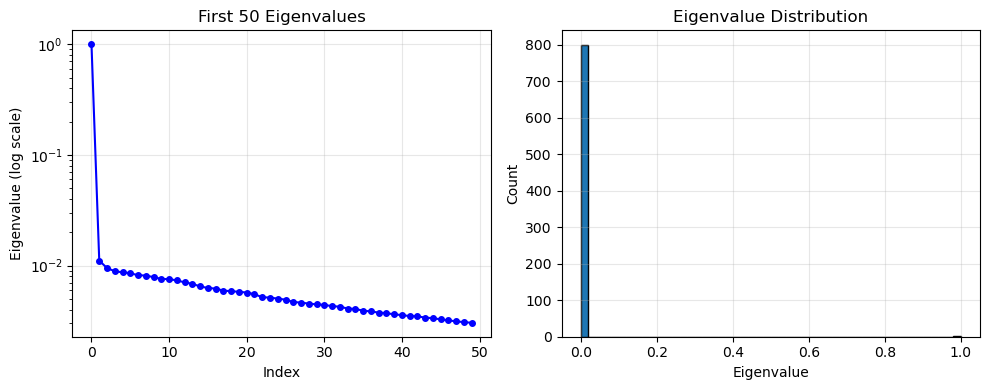

In [15]:
print("\n[EIGENVALUE ANALYSIS]")
print(f"Total eigenvalues: {len(lambda_ns)}")
print(f"Largest eigenvalue: {lambda_ns[0]:.6f}")
print(f"Smallest eigenvalue (after clipping): {lambda_ns[-1]:.6e}")

count_gt_1 = np.sum(lambda_ns > 1.0)
print(f"Eigenvalues > 1.0: {count_gt_1}")

count_lt_0 = np.sum(lambda_ns < 0.0)
print(f"Eigenvalues < 0.0 (after clipping): {count_lt_0}")

tol_small = 1e-6
count_near_0 = np.sum((lambda_ns >= 0.0) & (lambda_ns < tol_small))
print(f"Eigenvalues in [0, {tol_small:.0e}): {count_near_0}")

count_tiny_to_1 = np.sum((lambda_ns >= tol_small) & (lambda_ns <= 1.0))
print(f"Eigenvalues in [{tol_small:.0e}, 1.0]: {count_tiny_to_1}")

print(f"\nFirst 10 eigenvalues:")
for i in range(min(10, len(lambda_ns))):
    print(f"  λ[{i}] = {lambda_ns[i]:.8f}")
print("=" * 60 + "\n")

# Plot eigenvalue spectrum
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.semilogy(lambda_ns[:50], 'bo-', markersize=4)
plt.xlabel('Index')
plt.ylabel('Eigenvalue (log scale)')
plt.title('First 50 Eigenvalues')
plt.grid(True, alpha=0.3)

plt.subplot(122)
plt.hist(lambda_ns, bins=50, edgecolor='black')
plt.xlabel('Eigenvalue')
plt.ylabel('Count')
plt.title('Eigenvalue Distribution')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 14. Compute Inverse Weights for Gradient Calculations

In [16]:
lambda_ = -lambda_ns + 1
inv_lambda = np.zeros_like(lambda_)
inv_lambda[1:] = 1 / lambda_[1:]
inv_lambda = inv_lambda * epsilon
inv_K = phi @ np.diag(inv_lambda) @ phi.T

tol = 1e-6
lambda_ns_mod = np.copy(lambda_ns)
lambda_ns_mod[lambda_ns_mod < tol] = 0
below_tol = np.sum(lambda_ns < tol)
above_tol = n - below_tol
reg = 0.001
lambda_ns_inv = np.zeros_like(lambda_ns)
mask = lambda_ns >= tol
lambda_ns_inv[mask] = epsilon / (lambda_ns[mask] + reg)
inv_K_ns = phi @ np.diag(lambda_ns_inv) @ phi.T

print(f"[INFO] Number of eigenvalues above tolerance: {above_tol}")

[INFO] Number of eigenvalues above tolerance: 402


## 15. Particle Initialization

Initialize particles in a **localized region** of the torus to observe diffusion.

We place particles near the "top" of the torus tube (φ ≈ π/2) and at a specific θ location.

In [17]:
# KSWGD parameters
num_iter = 5000
h = 0.005  # Step size
m_init = 2000  # Initial number of particles to generate

# Initialize particles in a local region of the torus
# Location: near θ ≈ 0 and φ ≈ π/2 (top of the tube, front of the torus)
theta_init_center = 0.0
phi_init_center = np.pi / 2  # Top of the tube

# Generate particles with small spread around the center
theta_spread = 0.3  # Spread in θ direction
phi_spread = 0.3    # Spread in φ direction

theta_init = theta_init_center + np.random.uniform(-theta_spread, theta_spread, m_init)
phi_init = phi_init_center + np.random.uniform(-phi_spread, phi_spread, m_init)

# Wrap to [0, 2π)
theta_init = np.mod(theta_init, 2 * np.pi)
phi_init = np.mod(phi_init, 2 * np.pi)

# Convert to Cartesian
x_init = angles_to_cartesian(theta_init, phi_init, R, r)
m = x_init.shape[0]

print(f"[INFO] Initialized {m} particles in local region:")
print(f"       θ ∈ [{theta_init.min():.2f}, {theta_init.max():.2f}] (center: {theta_init_center:.2f})")
print(f"       φ ∈ [{phi_init.min():.2f}, {phi_init.max():.2f}] (center: {phi_init_center:.2f})")

# Initialize trajectory storage
x_t = np.zeros((m, d, num_iter), dtype=np.float64)
x_t[:, :, 0] = x_init

# Precompute quantities for KSWGD
p_tar = np.sum(data_kernel, axis=0)
D = np.sum(data_kernel / np.sqrt(p_tar) / np.sqrt(p_tar)[:, None], axis=1)

inv_K_ns_s_ns = phi @ np.diag(lambda_ns_inv * inv_lambda * lambda_ns_inv) @ phi.T
lambda_s_s_ns = inv_lambda * inv_lambda * lambda_ns_inv
lambda_s_s_ns = lambda_s_s_ns[:above_tol]
lambda_ns_s_ns = lambda_ns_inv * inv_lambda * lambda_ns_inv
lambda_ns_s_ns = lambda_ns_s_ns[:above_tol]

sum_x = np.zeros((m, d))

[INFO] Initialized 2000 particles in local region:
       θ ∈ [0.00, 6.28] (center: 0.00)
       φ ∈ [1.27, 1.87] (center: 1.57)


## 16. KSWGD Iteration Loop

**Data-driven learning**: The Koopman operator learned from the exact torus SDE dynamics.

After each update, we project particles back to the torus surface for numerical stability.

In [18]:
loop_start = time.time()
total_loop = num_iter - 1

# ============ TANGENT SPACE ESTIMATION METHODS ============

def compute_torus_normal(X, R, r):
    """
    [ANALYTIC - CHEATING] Compute outward unit normal vector using known torus formula.
    Requires knowing the manifold is a torus with parameters R, r.
    """
    theta, phi = cartesian_to_angles(X, R, r)
    normal = np.column_stack([
        np.cos(phi) * np.cos(theta),
        np.cos(phi) * np.sin(theta),
        np.sin(phi)
    ])
    return normal

def project_gradient_analytic(gradient, X, R, r):
    """
    [ANALYTIC - CHEATING] Project gradient to tangent space using known torus geometry.
    """
    normal = compute_torus_normal(X, R, r)
    normal_component = np.sum(gradient * normal, axis=1, keepdims=True)
    tangent_gradient = gradient - normal_component * normal
    return tangent_gradient

def estimate_tangent_space_local_pca(X_query, X_data, k_neighbors, manifold_dim):
    """
    [DATA-DRIVEN - NO CHEATING] Estimate tangent space using local PCA on nearby data points.
    
    For each query point, find k nearest neighbors in X_data, 
    compute local covariance, and extract top eigenvectors as tangent basis.
    
    Parameters:
        X_query: (m, d) query points where we need tangent space
        X_data: (n, d) data points on the manifold (X_tar)
        k_neighbors: number of neighbors for local PCA
        manifold_dim: intrinsic dimension of manifold
    
    Returns:
        tangent_bases: (m, d, manifold_dim) orthonormal basis for tangent space at each point
    """
    m_pts, d_ambient = X_query.shape
    tangent_bases = np.zeros((m_pts, d_ambient, manifold_dim))
    
    # Compute all pairwise distances between query and data
    sq_query = np.sum(X_query ** 2, axis=1)
    sq_data = np.sum(X_data ** 2, axis=1)
    dist2 = sq_query[:, None] + sq_data[None, :] - 2 * (X_query @ X_data.T)
    dist2 = np.maximum(dist2, 0)
    
    for i in range(m_pts):
        # Find k nearest neighbors in X_data
        neighbor_idx = np.argsort(dist2[i])[:k_neighbors]
        neighbors = X_data[neighbor_idx]  # (k, d)
        
        # Center the neighbors
        center = np.mean(neighbors, axis=0)
        neighbors_centered = neighbors - center
        
        # Local covariance matrix
        cov = neighbors_centered.T @ neighbors_centered / k_neighbors
        
        # Eigendecomposition - top eigenvectors span tangent space
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        # eigh returns ascending order, we want descending
        idx_sorted = np.argsort(eigenvalues)[::-1]
        
        # Take top manifold_dim eigenvectors as tangent basis
        tangent_bases[i] = eigenvectors[:, idx_sorted[:manifold_dim]]
    
    return tangent_bases

def project_gradient_local_pca(gradient, X_query, X_data, k_neighbors, manifold_dim):
    """
    [DATA-DRIVEN - NO CHEATING] Project gradient to tangent space estimated via local PCA.
    
    grad_tangent = sum_i (grad · e_i) e_i  for tangent basis vectors e_i
    """
    tangent_bases = estimate_tangent_space_local_pca(X_query, X_data, k_neighbors, manifold_dim)
    
    m_pts = gradient.shape[0]
    tangent_gradient = np.zeros_like(gradient)
    
    for i in range(m_pts):
        # Project gradient onto tangent space spanned by basis vectors
        basis = tangent_bases[i]  # (d, manifold_dim)
        # grad_tangent = basis @ basis.T @ gradient (projection matrix P = VV^T)
        tangent_gradient[i] = basis @ (basis.T @ gradient[i])
    
    return tangent_gradient

def project_gradient_to_tangent_space(gradient, X, X_data, R, r, method, k_neighbors, manifold_dim):
    """
    Unified interface for tangent space projection.
    """
    if method == 'analytic':
        return project_gradient_analytic(gradient, X, R, r)
    elif method == 'local_pca':
        return project_gradient_local_pca(gradient, X, X_data, k_neighbors, manifold_dim)
    else:
        raise ValueError(f"Unknown tangent space method: {method}")

if USE_GPU:
    # Stage constants on GPU
    X_tar_gpu = cp.asarray(X_tar)
    p_tar_gpu = cp.asarray(p_tar)
    sq_tar_gpu = cp.asarray(sq_tar)
    D_gpu = cp.asarray(D)
    phi_gpu = cp.asarray(phi[:, :above_tol])
    lambda_ns_s_ns_gpu = cp.asarray(lambda_ns_s_ns)
    x_t_gpu = cp.asarray(x_t)
    diag_lambda_gpu = cp.diag(lambda_ns_s_ns_gpu)
    
    # Iteration loop (GPU)
    for t in range(num_iter - 1):
        x_slice = x_t_gpu[:, :, t]
        grad_matrix = grad_ker1(x_slice, X_tar_gpu, p_tar_gpu, sq_tar_gpu, D_gpu, epsilon)
        cross_matrix = K_tar_eval(X_tar_gpu, x_slice, p_tar_gpu, sq_tar_gpu, D_gpu, epsilon)
        
        sum_x_gpu = cp.zeros((m, d))
        for i in range(d):
            sum_x_gpu[:, i] = cp.sum(
                grad_matrix[:, :, i] @ phi_gpu @ diag_lambda_gpu @ phi_gpu.T @ cross_matrix,
                axis=1
            )
        
        # Compute Euclidean gradient
        euclidean_gradient = (h / m) * sum_x_gpu
        
        # Optionally project to tangent space (Riemannian gradient)
        if USE_RIEMANNIAN_GRADIENT:
            euclidean_gradient_np = cp.asnumpy(euclidean_gradient)
            x_slice_np = cp.asnumpy(x_slice)
            riemannian_gradient = project_gradient_to_tangent_space(
                euclidean_gradient_np, x_slice_np, X_tar, R, r,
                method=TANGENT_SPACE_METHOD,
                k_neighbors=LOCAL_PCA_K_NEIGHBORS,
                manifold_dim=MANIFOLD_DIM
            )
            gradient_to_use = cp.asarray(riemannian_gradient)
        else:
            gradient_to_use = euclidean_gradient
        
        # Update particles
        x_new = x_slice - gradient_to_use
        
        # Optionally project back to torus surface
        if USE_PROJECTION:
            x_new_np = cp.asnumpy(x_new)
            x_new_projected = angles_to_cartesian(*cartesian_to_angles(x_new_np, R, r), R, r)
            x_t_gpu[:, :, t + 1] = cp.asarray(x_new_projected)
        else:
            x_t_gpu[:, :, t + 1] = x_new
        
        done = t + 1
        if done == total_loop or (done % max(1, total_loop // 100) == 0):
            _print_progress(done, total_loop, loop_start, prefix="[Kernel-EDMD-GPU] ")
    
    x_t = cp.asnumpy(x_t_gpu)
else:
    # CPU iteration loop
    for t in range(num_iter - 1):
        grad_matrix = grad_ker1(x_t[:, :, t], X_tar, p_tar, sq_tar, D, epsilon)
        cross_matrix = K_tar_eval(X_tar, x_t[:, :, t], p_tar, sq_tar, D, epsilon)
        
        for i in range(d):
            sum_x[:, i] = np.sum(
                grad_matrix[:, :, i] @ phi[:, :above_tol] @ np.diag(lambda_ns_s_ns) @ phi[:, :above_tol].T @ cross_matrix,
                axis=1
            )
        
        # Compute Euclidean gradient
        euclidean_gradient = (h / m) * sum_x
        
        # Optionally project to tangent space (Riemannian gradient)
        if USE_RIEMANNIAN_GRADIENT:
            riemannian_gradient = project_gradient_to_tangent_space(
                euclidean_gradient, x_t[:, :, t], X_tar, R, r,
                method=TANGENT_SPACE_METHOD,
                k_neighbors=LOCAL_PCA_K_NEIGHBORS,
                manifold_dim=MANIFOLD_DIM
            )
            gradient_to_use = riemannian_gradient
        else:
            gradient_to_use = euclidean_gradient
        
        # Update particles
        x_new = x_t[:, :, t] - gradient_to_use
        
        # Optionally project back to torus surface
        if USE_PROJECTION:
            x_new_projected = angles_to_cartesian(*cartesian_to_angles(x_new, R, r), R, r)
            x_t[:, :, t + 1] = x_new_projected
        else:
            x_t[:, :, t + 1] = x_new
        
        done = t + 1
        if done == total_loop or (done % max(1, total_loop // 100) == 0):
            _print_progress(done, total_loop, loop_start, prefix="[Kernel-EDMD-CPU] ")

print()
_t = _print_phase("Iteration loop total", loop_start)

[Kernel-EDMD-GPU] [==============================] 100.0% | iter 4999/4999 | elapsed 13:10 | eta 00:00
[TIMER] Iteration loop total: 790.429s


## 17. Visualize Results (3D)

- **Blue dots**: Target distribution (uniform on torus)
- **Red solid circles**: Initial particle positions (localized)
- **Magenta hollow circles**: Final particle positions (should spread out)

[SAVED] figures/torus/kswgd_1_target.pdf & .png


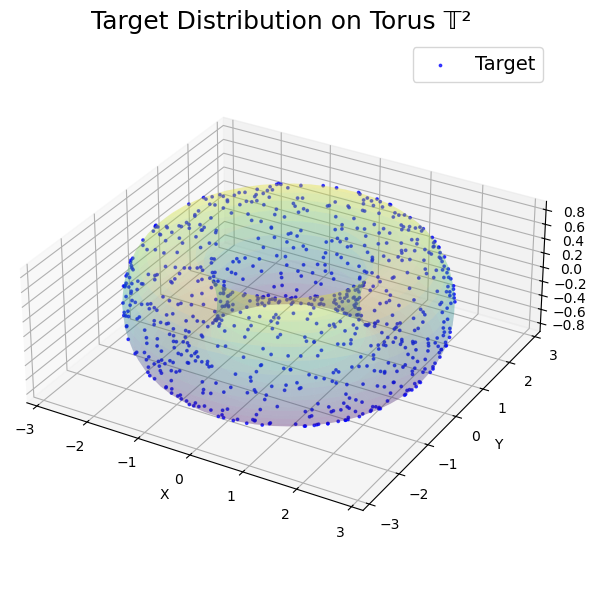

Kernel: Geodesic-like, n=800
[SAVED] figures/torus/kswgd_2_initial.pdf & .png


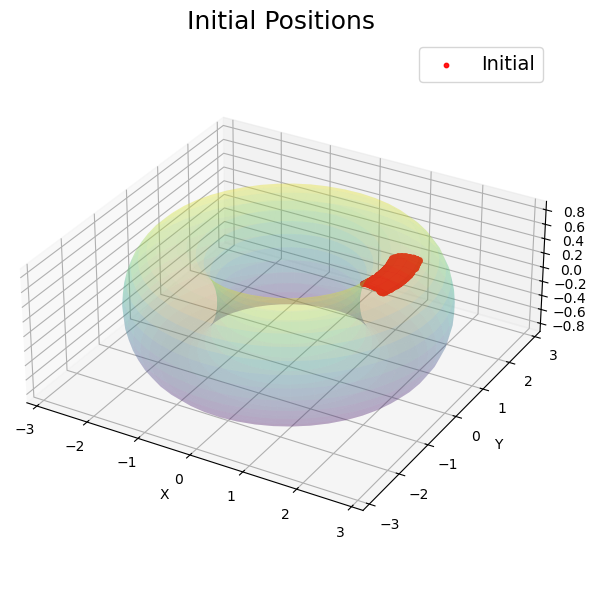

m=2000 particles
[SAVED] figures/torus/kswgd_3_final.pdf & .png


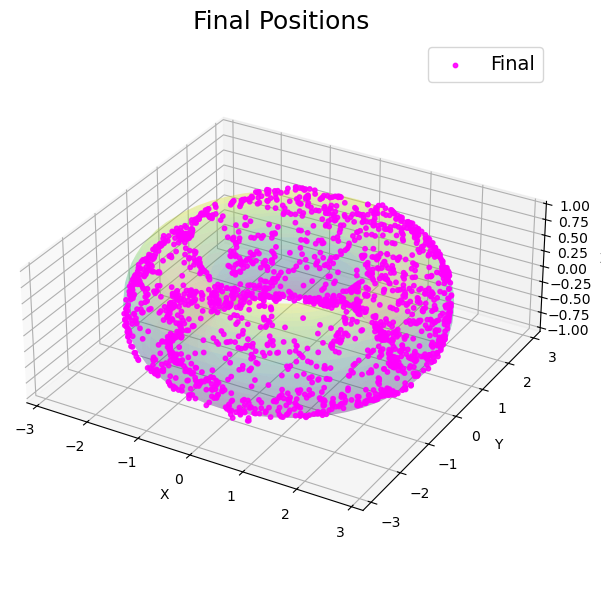

after 5000 iterations
[SAVED] figures/torus/kswgd_initial_interactive.html


[SAVED] figures/torus/kswgd_final_interactive.html


Kernel: Geodesic-like
[SAVED] figures/torus/kswgd_torus_results.pdf (vector format for LaTeX)
[SAVED] figures/torus/kswgd_torus_results.png (raster format)


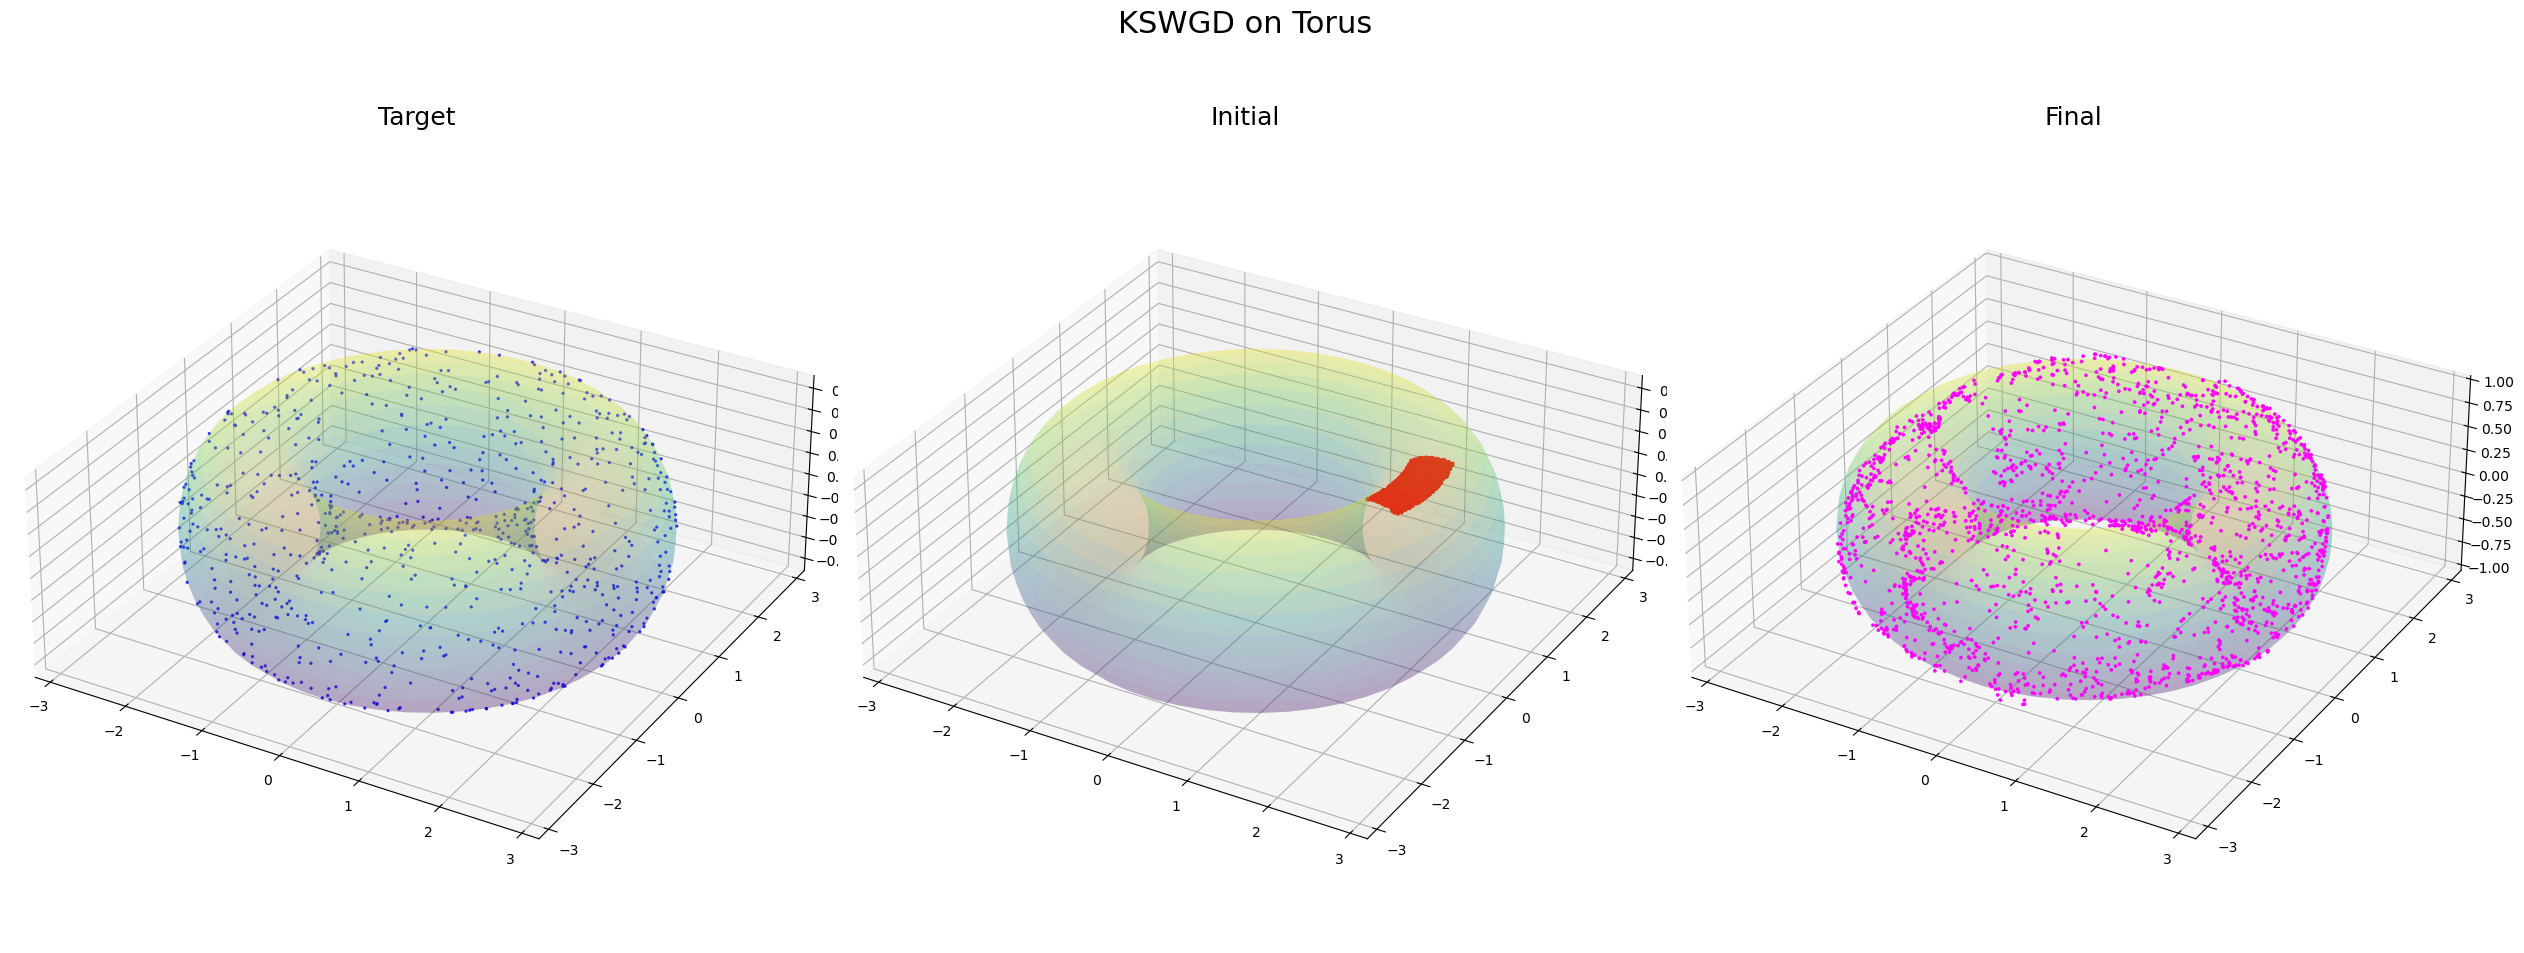

Geodesic-like Kernel | Riemannian: local_pca


In [19]:
# Create torus surface mesh for reference
theta_surf = np.linspace(0, 2 * np.pi, 50)
phi_surf = np.linspace(0, 2 * np.pi, 30)
THETA_S, PHI_S = np.meshgrid(theta_surf, phi_surf)
X_surf = (R + r * np.cos(PHI_S)) * np.cos(THETA_S)
Y_surf = (R + r * np.cos(PHI_S)) * np.sin(THETA_S)
Z_surf = r * np.sin(PHI_S)

# ============ Figure 1: Target distribution only ============
fig1 = plt.figure(figsize=(8, 6))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot_surface(X_surf, Y_surf, Z_surf, alpha=0.2, cmap='viridis', edgecolor='none')
ax1.scatter(X_tar[:, 0], X_tar[:, 1], X_tar[:, 2], s=3, c='blue', alpha=0.7, label='Target')
ax1.set_title('Target Distribution on Torus 𝕋²', fontsize=18)
ax1.legend(fontsize=14)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_box_aspect([1, 1, 0.4])
plt.tight_layout()
plt.savefig('figures/torus/kswgd_1_target.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/torus/kswgd_1_target.png', dpi=300, bbox_inches='tight')
print("[SAVED] figures/torus/kswgd_1_target.pdf & .png")
plt.show()
print(f'Kernel: {kernel_name}, n={n}')

# ============ Figure 2: Initial positions only ============
fig2 = plt.figure(figsize=(8, 6))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot_surface(X_surf, Y_surf, Z_surf, alpha=0.2, cmap='viridis', edgecolor='none')
ax2.scatter(x_t[:, 0, 0], x_t[:, 1, 0], x_t[:, 2, 0], s=10, c='red', alpha=0.9, label='Initial')
ax2.set_title('Initial Positions', fontsize=18)
ax2.legend(fontsize=14)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_box_aspect([1, 1, 0.4])
plt.tight_layout()
plt.savefig('figures/torus/kswgd_2_initial.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/torus/kswgd_2_initial.png', dpi=300, bbox_inches='tight')
print("[SAVED] figures/torus/kswgd_2_initial.pdf & .png")
plt.show()
print(f'm={m} particles')

# ============ Figure 3: Final positions only ============
fig3 = plt.figure(figsize=(8, 6))
ax3 = fig3.add_subplot(111, projection='3d')
ax3.plot_surface(X_surf, Y_surf, Z_surf, alpha=0.2, cmap='viridis', edgecolor='none')
ax3.scatter(x_t[:, 0, -1], x_t[:, 1, -1], x_t[:, 2, -1], s=10, c='magenta', alpha=0.9, label='Final')
ax3.set_title('Final Positions', fontsize=18)
ax3.legend(fontsize=14)
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
ax3.set_box_aspect([1, 1, 0.4])
plt.tight_layout()
plt.savefig('figures/torus/kswgd_3_final.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/torus/kswgd_3_final.png', dpi=300, bbox_inches='tight')
print("[SAVED] figures/torus/kswgd_3_final.pdf & .png")
plt.show()
print(f'after {num_iter} iterations')

# ============ Interactive Plotly 3D Plots (can rotate!) ============
import plotly.graph_objects as go

# Create torus surface mesh for Plotly
theta_surf_p = np.linspace(0, 2 * np.pi, 50)
phi_surf_p = np.linspace(0, 2 * np.pi, 30)
THETA_P, PHI_P = np.meshgrid(theta_surf_p, phi_surf_p)
X_surf_p = (R + r * np.cos(PHI_P)) * np.cos(THETA_P)
Y_surf_p = (R + r * np.cos(PHI_P)) * np.sin(THETA_P)
Z_surf_p = r * np.sin(PHI_P)

# ============ Interactive Figure 1: Initial positions ============
fig_init = go.Figure()
fig_init.add_trace(go.Surface(
    x=X_surf_p, y=Y_surf_p, z=Z_surf_p,
    opacity=0.3, colorscale='Viridis', showscale=False, name='Torus'
))
fig_init.add_trace(go.Scatter3d(
    x=x_t[:, 0, 0], y=x_t[:, 1, 0], z=x_t[:, 2, 0],
    mode='markers', marker=dict(size=3, color='red', opacity=0.9),
    name=f'Initial (m={m})'
))
fig_init.update_layout(
    title=f'Initial Particle Positions | m={m} particles',
    scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', aspectmode='data'),
    width=800, height=600
)
fig_init.write_html('figures/torus/kswgd_initial_interactive.html', include_mathjax='cdn')
print("[SAVED] figures/torus/kswgd_initial_interactive.html")
fig_init.show()

# ============ Interactive Figure 3: Final positions ============
fig_final = go.Figure()
fig_final.add_trace(go.Surface(
    x=X_surf_p, y=Y_surf_p, z=Z_surf_p,
    opacity=0.3, colorscale='Viridis', showscale=False, name='Torus'
))
fig_final.add_trace(go.Scatter3d(
    x=x_t[:, 0, -1], y=x_t[:, 1, -1], z=x_t[:, 2, -1],
    mode='markers', marker=dict(size=3, color='magenta', opacity=0.9),
    name=f'Final (iter={num_iter})'
))
# Also add target for comparison (semi-transparent)
fig_final.add_trace(go.Scatter3d(
    x=X_tar[:, 0], y=X_tar[:, 1], z=X_tar[:, 2],
    mode='markers', marker=dict(size=2, color='blue', opacity=0.3),
    name=f'Target (n={n})'
))
fig_final.update_layout(
    title=f'Final Positions after {num_iter} iterations',
    scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', aspectmode='data'),
    width=800, height=600
)
fig_final.write_html('figures/torus/kswgd_final_interactive.html', include_mathjax='cdn')
print("[SAVED] figures/torus/kswgd_final_interactive.html")
fig_final.show()
print(f'Kernel: {kernel_name}')

# ============ Save static figures as PDF (vector format for LaTeX) ============
# Matplotlib static figures for paper
fig_pdf, axes_pdf = plt.subplots(1, 3, figsize=(25, 10), subplot_kw={'projection': '3d'})

# Target
axes_pdf[0].plot_surface(X_surf, Y_surf, Z_surf, alpha=0.2, cmap='viridis', edgecolor='none')
axes_pdf[0].scatter(X_tar[:, 0], X_tar[:, 1], X_tar[:, 2], s=2, c='blue', alpha=0.7)
axes_pdf[0].set_title('Target', fontsize=18, pad=-10)
axes_pdf[0].set_box_aspect([1, 1, 0.4])

# Initial
axes_pdf[1].plot_surface(X_surf, Y_surf, Z_surf, alpha=0.2, cmap='viridis', edgecolor='none')
axes_pdf[1].scatter(x_t[:, 0, 0], x_t[:, 1, 0], x_t[:, 2, 0], s=3, c='red', alpha=0.9)
axes_pdf[1].set_title('Initial', fontsize=18, pad=-10)
axes_pdf[1].set_box_aspect([1, 1, 0.4])

# Final
axes_pdf[2].plot_surface(X_surf, Y_surf, Z_surf, alpha=0.2, cmap='viridis', edgecolor='none')
axes_pdf[2].scatter(x_t[:, 0, -1], x_t[:, 1, -1], x_t[:, 2, -1], s=3, c='magenta', alpha=0.9)
axes_pdf[2].set_title('Final', fontsize=18, pad=-10)
axes_pdf[2].set_box_aspect([1, 1, 0.4])

plt.suptitle('KSWGD on Torus', fontsize=22, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('figures/torus/kswgd_torus_results.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/torus/kswgd_torus_results.png', dpi=300, bbox_inches='tight')
print("[SAVED] figures/torus/kswgd_torus_results.pdf (vector format for LaTeX)")
print("[SAVED] figures/torus/kswgd_torus_results.png (raster format)")
plt.show()
print(f'{kernel_name} Kernel | Riemannian: {TANGENT_SPACE_METHOD}')

## 18. Angular Coordinate Analysis

Visualize how particles spread in $(\theta, \phi)$ coordinates.

Saved: figures/torus/kswgd_4_angular_coordinates.pdf/.png


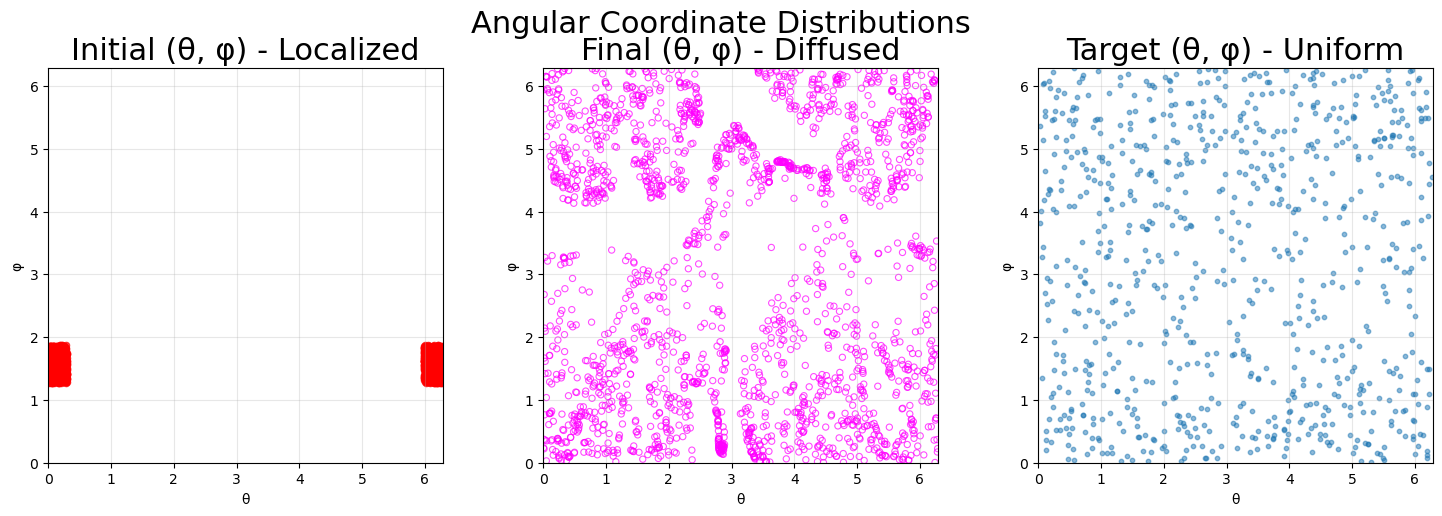


[SPREAD ANALYSIS]
Initial θ: mean=3.251, std=2.992
Final θ:   mean=3.069, std=1.853
Initial φ: mean=1.566, std=0.169
Final φ:   mean=3.071, std=2.112
Saved: figures/torus/kswgd_5_radius_analysis.pdf/.png


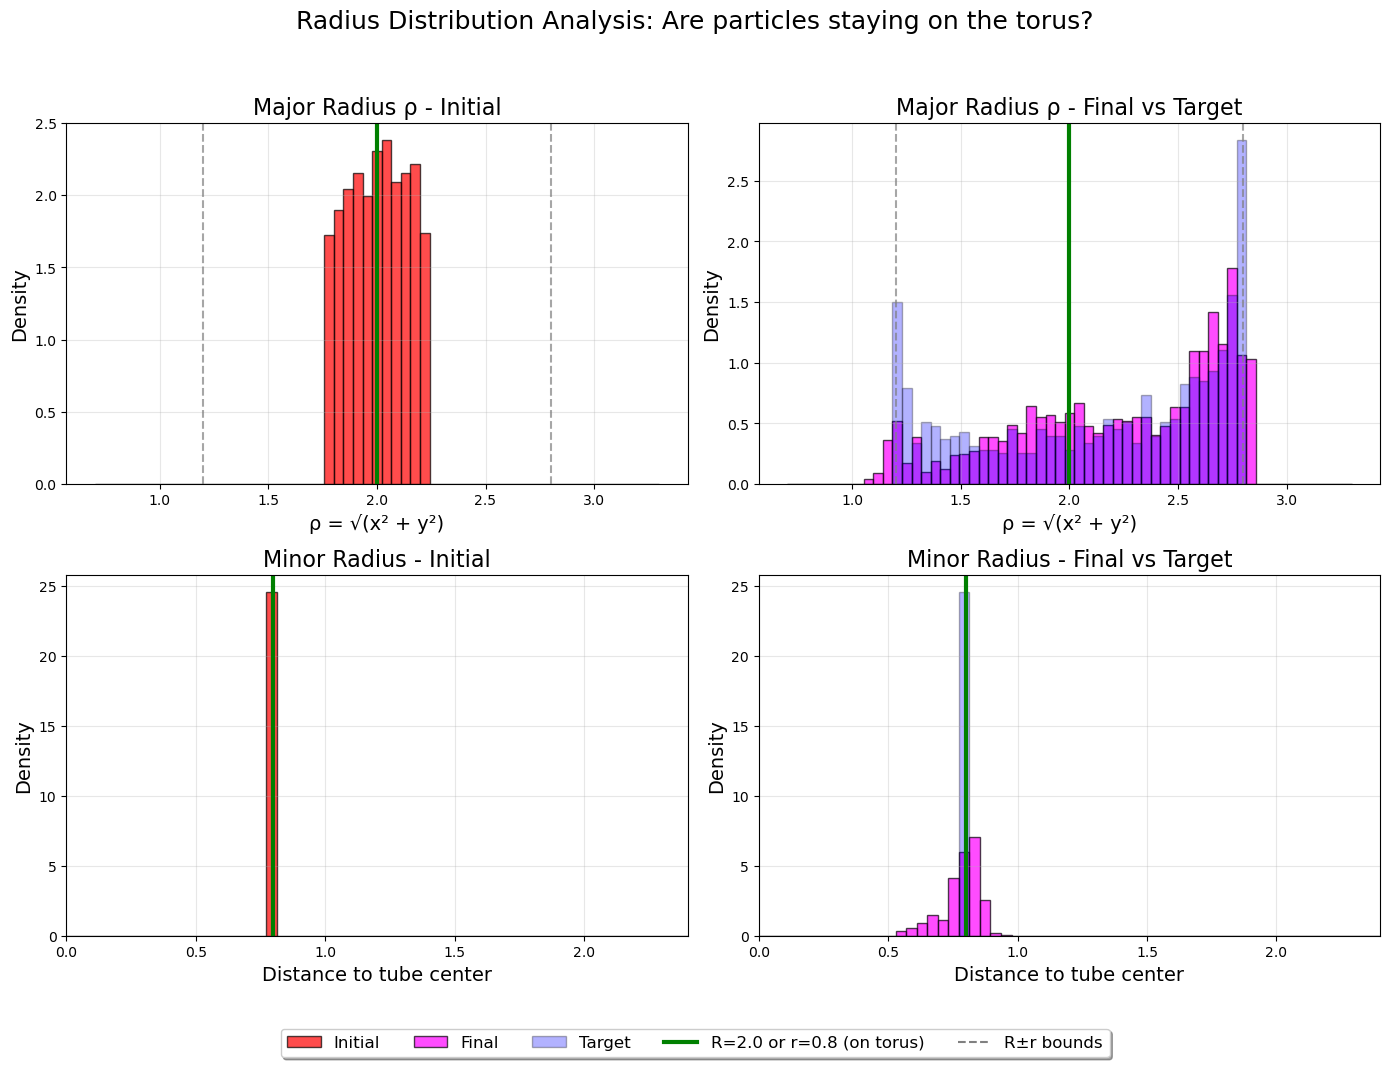


[RADIUS ANALYSIS] - Key metric: do particles stay on torus surface?

1. Major radius ρ = √(x²+y²) [distance from z-axis]:
   On torus surface: ρ ∈ [R-r, R+r] = [1.20, 2.80]
   Initial (φ≈π/2 → ρ≈R): mean=2.0041, std=0.1344
   Final:                  mean=2.2295, std=0.4886
   Target:                 mean=2.1614, std=0.5509

2. Minor radius [distance to tube center]:
   On torus surface: dist = r = 0.80 (exactly!)
   Initial:  mean=0.8000, std=0.000000
   Final:    mean=0.7833, std=0.0738
   Target:   mean=0.8000, std=0.000000

[TORUS CHECK]

[TORUS CHECK]
   Final particles off torus (|dist-r|>0.1):    306/2000 (15.3%)
   Initial particles off torus (|dist-r|>0.01): 0/2000 (0.0%)
   Initial particles off torus (|dist-r|>0.01): 0/2000 (0.0%)
   Final particles off torus (|dist-r|>0.1):    306/2000 (15.3%)


In [20]:
# Convert initial and final positions to angular coordinates
theta_init_final, phi_init_final = cartesian_to_angles(x_t[:, :, 0], R, r)
theta_final, phi_final = cartesian_to_angles(x_t[:, :, -1], R, r)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Initial distribution in angular coordinates
axes[0].scatter(theta_init_final, phi_init_final, s=20, c='red', alpha=0.7)
axes[0].set_xlabel('θ')
axes[0].set_ylabel('φ')
axes[0].set_title('Initial (θ, φ) - Localized', fontsize=22)
axes[0].set_xlim(0, 2*np.pi)
axes[0].set_ylim(0, 2*np.pi)
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)

# Final distribution in angular coordinates
axes[1].scatter(theta_final, phi_final, s=20, facecolors='none', edgecolors='magenta', linewidths=0.8, alpha=0.7)
axes[1].set_xlabel('θ')
axes[1].set_ylabel('φ')
axes[1].set_title('Final (θ, φ) - Diffused', fontsize=22)
axes[1].set_xlim(0, 2*np.pi)
axes[1].set_ylim(0, 2*np.pi)
axes[1].set_aspect('equal')
axes[1].grid(True, alpha=0.3)

# Target distribution in angular coordinates
axes[2].scatter(theta_tar, phi_tar, s=10, c='C0', alpha=0.5)
axes[2].set_xlabel('θ')
axes[2].set_ylabel('φ')
axes[2].set_title('Target (θ, φ) - Uniform', fontsize=22)
axes[2].set_xlim(0, 2*np.pi)
axes[2].set_ylim(0, 2*np.pi)
axes[2].set_aspect('equal')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Angular Coordinate Distributions', fontsize=22)
plt.tight_layout()
plt.savefig('figures/torus/kswgd_4_angular_coordinates.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/torus/kswgd_4_angular_coordinates.png', dpi=300, bbox_inches='tight')
print("Saved: figures/torus/kswgd_4_angular_coordinates.pdf/.png")
plt.show()

# Compute spread statistics
print("\n[SPREAD ANALYSIS]")
print(f"Initial θ: mean={np.mean(theta_init_final):.3f}, std={np.std(theta_init_final):.3f}")
print(f"Final θ:   mean={np.mean(theta_final):.3f}, std={np.std(theta_final):.3f}")
print(f"Initial φ: mean={np.mean(phi_init_final):.3f}, std={np.std(phi_init_final):.3f}")
print(f"Final φ:   mean={np.mean(phi_final):.3f}, std={np.std(phi_final):.3f}")

# ============ Figure 4: Radius Analysis ============
# Compute radii for initial and final positions
# Major radius ρ = sqrt(x² + y²) is distance from z-axis
# Minor radius = distance from tube center (should be exactly r on torus surface)

# Initial positions
x_init_pos = x_t[:, 0, 0]
y_init_pos = x_t[:, 1, 0]
z_init_pos = x_t[:, 2, 0]
rho_init = np.sqrt(x_init_pos**2 + y_init_pos**2)  # Distance from z-axis (major radius)
dist_to_tube_center_init = np.sqrt((rho_init - R)**2 + z_init_pos**2)  # Minor radius

# Final positions
x_final_pos = x_t[:, 0, -1]
y_final_pos = x_t[:, 1, -1]
z_final_pos = x_t[:, 2, -1]
rho_final = np.sqrt(x_final_pos**2 + y_final_pos**2)  # Distance from z-axis (major radius)
dist_to_tube_center_final = np.sqrt((rho_final - R)**2 + z_final_pos**2)  # Minor radius

# Target positions for reference
rho_tar = np.sqrt(X_tar[:, 0]**2 + X_tar[:, 1]**2)
dist_to_tube_center_tar = np.sqrt((rho_tar - R)**2 + X_tar[:, 2]**2)

# Create 2x2 figure for radius distributions with extra space at bottom for legend
fig_rad, axes_rad = plt.subplots(2, 2, figsize=(14, 11))

# ===== Row 1: Major radius ρ (distance from z-axis) =====
# Initial: since φ≈π/2, we have cos(φ)≈0, so ρ = R + r*cos(φ) ≈ R = 2.0
rho_bins = np.linspace(R - r - 0.5, R + r + 0.5, 60)

# Plot 1: Major radius ρ - Initial (should be delta-like at ρ≈R since φ≈π/2)
axes_rad[0, 0].hist(rho_init, bins=rho_bins, color='red', alpha=0.7, edgecolor='black', density=True)
axes_rad[0, 0].axvline(R, color='green', linestyle='-', linewidth=3)
axes_rad[0, 0].axvline(R - r, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
axes_rad[0, 0].axvline(R + r, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
axes_rad[0, 0].set_xlabel('ρ = √(x² + y²)', fontsize=14)
axes_rad[0, 0].set_ylabel('Density', fontsize=14)
axes_rad[0, 0].set_title(f'Major Radius ρ - Initial', fontsize=16)
axes_rad[0, 0].grid(True, alpha=0.3)

# Plot 2: Major radius ρ - Final
axes_rad[0, 1].hist(rho_final, bins=rho_bins, color='magenta', alpha=0.7, edgecolor='black', density=True)
axes_rad[0, 1].hist(rho_tar, bins=rho_bins, color='blue', alpha=0.3, edgecolor='black', density=True)
axes_rad[0, 1].axvline(R, color='green', linestyle='-', linewidth=3)
axes_rad[0, 1].axvline(R - r, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
axes_rad[0, 1].axvline(R + r, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
axes_rad[0, 1].set_xlabel('ρ = √(x² + y²)', fontsize=14)
axes_rad[0, 1].set_ylabel('Density', fontsize=14)
axes_rad[0, 1].set_title(f'Major Radius ρ - Final vs Target', fontsize=16)
axes_rad[0, 1].grid(True, alpha=0.3)

# ===== Row 2: Minor radius (distance to tube center) =====
# On torus surface, this should be exactly r = 0.8
minor_bins = np.linspace(0, r * 3, 60)

# Plot 3: Minor radius - Initial (should be delta-like at r=0.8)
axes_rad[1, 0].hist(dist_to_tube_center_init, bins=minor_bins, color='red', alpha=0.7, edgecolor='black', density=True)
axes_rad[1, 0].axvline(r, color='green', linestyle='-', linewidth=3)
axes_rad[1, 0].set_xlabel('Distance to tube center', fontsize=14)
axes_rad[1, 0].set_ylabel('Density', fontsize=14)
axes_rad[1, 0].set_title(f'Minor Radius - Initial', fontsize=16)
axes_rad[1, 0].grid(True, alpha=0.3)
axes_rad[1, 0].set_xlim(0, r * 3)

# Plot 4: Minor radius - Final (should still be near r=0.8 if KSWGD works)
axes_rad[1, 1].hist(dist_to_tube_center_final, bins=minor_bins, color='magenta', alpha=0.7, edgecolor='black', density=True)
axes_rad[1, 1].hist(dist_to_tube_center_tar, bins=minor_bins, color='blue', alpha=0.3, edgecolor='black', density=True)
axes_rad[1, 1].axvline(r, color='green', linestyle='-', linewidth=3)
axes_rad[1, 1].set_xlabel('Distance to tube center', fontsize=14)
axes_rad[1, 1].set_ylabel('Density', fontsize=14)
axes_rad[1, 1].set_title(f'Minor Radius - Final vs Target', fontsize=16)
axes_rad[1, 1].grid(True, alpha=0.3)
axes_rad[1, 1].set_xlim(0, r * 3)

# Create shared legend at bottom
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Patch(facecolor='red', alpha=0.7, edgecolor='black', label='Initial'),
    Patch(facecolor='magenta', alpha=0.7, edgecolor='black', label='Final'),
    Patch(facecolor='blue', alpha=0.3, edgecolor='black', label='Target'),
    Line2D([0], [0], color='green', linewidth=3, label=f'R={R:.1f} or r={r:.1f} (on torus)'),
    Line2D([0], [0], color='gray', linestyle='--', linewidth=1.5, label=f'R±r bounds'),
]
fig_rad.legend(handles=legend_elements, loc='lower center', ncol=5, fontsize=12, 
               bbox_to_anchor=(0.5, 0.02), frameon=True, fancybox=True, shadow=True)

plt.suptitle('Radius Distribution Analysis: Are particles staying on the torus?', fontsize=18, y=0.98)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.savefig('figures/torus/kswgd_5_radius_analysis.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/torus/kswgd_5_radius_analysis.png', dpi=300, bbox_inches='tight')
print("Saved: figures/torus/kswgd_5_radius_analysis.pdf/.png")
plt.show()

# Print radius statistics
print("\n[RADIUS ANALYSIS] - Key metric: do particles stay on torus surface?")
print(f"\n1. Major radius ρ = √(x²+y²) [distance from z-axis]:")
print(f"   On torus surface: ρ ∈ [R-r, R+r] = [{R-r:.2f}, {R+r:.2f}]")
print(f"   Initial (φ≈π/2 → ρ≈R): mean={np.mean(rho_init):.4f}, std={np.std(rho_init):.4f}")
print(f"   Final:                  mean={np.mean(rho_final):.4f}, std={np.std(rho_final):.4f}")
print(f"   Target:                 mean={np.mean(rho_tar):.4f}, std={np.std(rho_tar):.4f}")

print(f"\n2. Minor radius [distance to tube center]:")
print(f"   On torus surface: dist = r = {r:.2f} (exactly!)")
print(f"   Initial:  mean={np.mean(dist_to_tube_center_init):.4f}, std={np.std(dist_to_tube_center_init):.6f}")
print(f"   Final:    mean={np.mean(dist_to_tube_center_final):.4f}, std={np.std(dist_to_tube_center_final):.4f}")
print(f"   Target:   mean={np.mean(dist_to_tube_center_tar):.4f}, std={np.std(dist_to_tube_center_tar):.6f}")

# Check if particles flew off the torus
off_torus_init = np.sum(np.abs(dist_to_tube_center_init - r) > 0.01)
off_torus_final = np.sum(np.abs(dist_to_tube_center_final - r) > 0.1)

print(f"\n[TORUS CHECK]")
print(f"\n[TORUS CHECK]")
print(f"   Final particles off torus (|dist-r|>0.1):    {off_torus_final}/{m} ({100*off_torus_final/m:.1f}%)")

print(f"   Initial particles off torus (|dist-r|>0.01): {off_torus_init}/{m} ({100*off_torus_init/m:.1f}%)")
print(f"   Initial particles off torus (|dist-r|>0.01): {off_torus_init}/{m} ({100*off_torus_init/m:.1f}%)")
print(f"   Final particles off torus (|dist-r|>0.1):    {off_torus_final}/{m} ({100*off_torus_final/m:.1f}%)")

## 19. Scatter Matrix Analysis

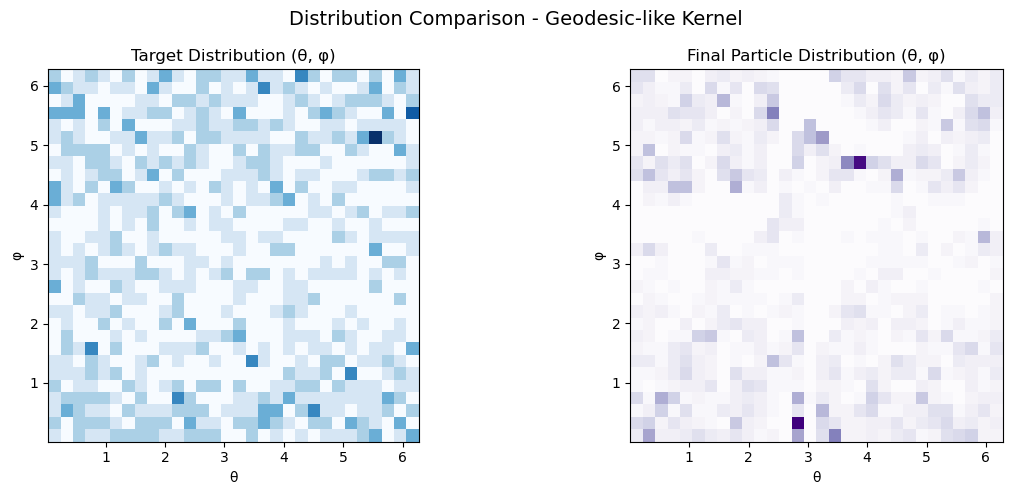

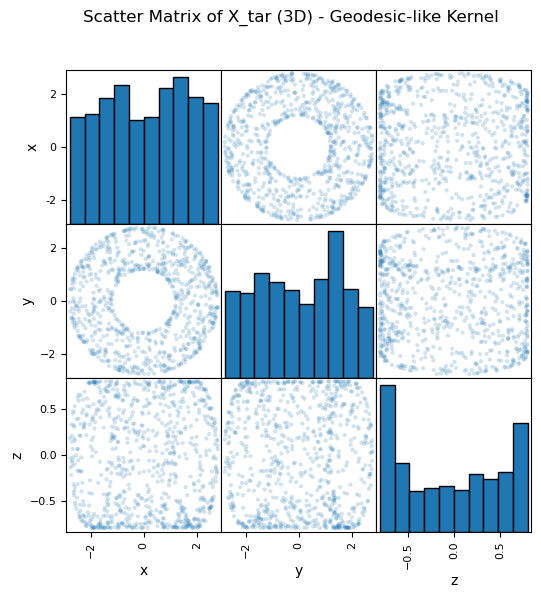

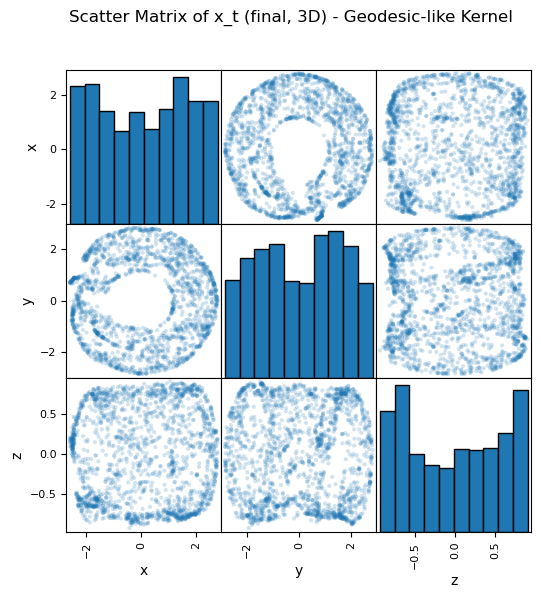

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Target distribution histogram
axes[0].hist2d(theta_tar, phi_tar, bins=30, cmap='Blues')
axes[0].set_xlabel('θ')
axes[0].set_ylabel('φ')
axes[0].set_title('Target Distribution (θ, φ)')
axes[0].set_aspect('equal')

# Final particle distribution histogram
axes[1].hist2d(theta_final, phi_final, bins=30, cmap='Purples')
axes[1].set_xlabel('θ')
axes[1].set_ylabel('φ')
axes[1].set_title('Final Particle Distribution (θ, φ)')
axes[1].set_aspect('equal')

plt.suptitle(f'Distribution Comparison - {kernel_name} Kernel', fontsize=14)
plt.tight_layout()
plt.show()

# 3D scatter matrices
pd.plotting.scatter_matrix(
    pd.DataFrame(X_tar, columns=['x', 'y', 'z']),
    alpha=0.2,
    figsize=(6, 6),
    diagonal='hist',
    hist_kwds={'edgecolor': 'black'}
)
plt.suptitle(f'Scatter Matrix of X_tar (3D) - {kernel_name} Kernel')
plt.show()

pd.plotting.scatter_matrix(
    pd.DataFrame(x_t[:, :, -1], columns=['x', 'y', 'z']),
    alpha=0.2,
    figsize=(6, 6),
    diagonal='hist',
    hist_kwds={'edgecolor': 'black'}
)
plt.suptitle(f'Scatter Matrix of x_t (final, 3D) - {kernel_name} Kernel')
plt.show()